In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import collections
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

from FairReg import FairReg
from evaluation import get_stats, get_risk_unf_wrt_eps
from evaluation_measures import DP_unfairness, prob_unfairness, prob_unfairness_summary, DP_unfairness_summary
from plots import plot_distributions_compare, plot_predictions_compare, plot_distributions, plot_predictions, plot_risk_history,plot_unfairness_history,plot_unfairness_vs_risk, plot_risk_unf_compare
from data_prep import get_lawschool_data, get_communities_data, get_adult_data, get_frequencies

# Example 

Getting data

In [18]:
X, S, y = get_adult_data()

In [3]:
y=y/100
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
y = pd.Series(y_scaled.flatten(), index=y.index)
sample_size = 2000 
X, _, S, _, y ,_ = train_test_split(X, S, y, test_size=1 - sample_size / (len(X)), random_state=0)

In [4]:
p = get_frequencies(S)

Splitting data into **train**, **unlab** and **test** groups

In [5]:
TRAIN_SIZE, UNLAB_SIZE, TEST_SIZE = 0.4, 0.4, 0.2

X_train, X_, S_train, S_, y_train, y_ = train_test_split(X, S, y, train_size = TRAIN_SIZE, stratify = S)
X_unlab, X_test, S_unlab, S_test, y_unlab, y_test = train_test_split(X_, S_, y_, test_size = TEST_SIZE/(1-TRAIN_SIZE), stratify = S_)

Training the **base (unfair) regression** method to predict **y** given **X**

In [6]:
reg = LinearRegression(fit_intercept=True)
reg.fit(X_train,y_train)

LinearRegression()

Training a **classifier** to predict **S** given **X**

In [7]:
clf = LogisticRegression()
clf.fit(X_train,S_train)

LogisticRegression()

Training the **fair regression** to predict **y** given **X**

In [8]:
T = 10000

fair_reg = FairReg(reg, clf, B=1, K=2,  p=p, eps=[0.00001, 0.00001], T=T, keep_history = False)
fair_reg.fit(X_unlab)

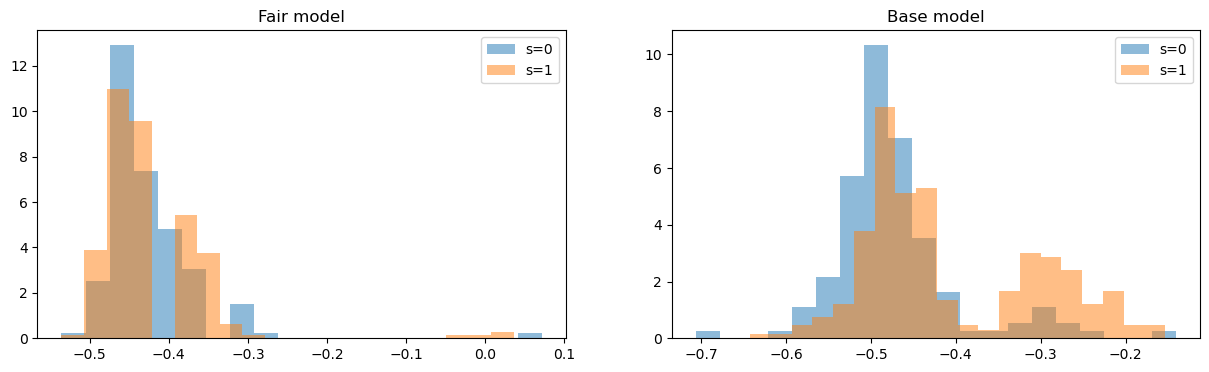

In [9]:
plot_distributions_compare(fair_reg, reg, X_test, S_test)

# Statistics: Risk vs Unfairness

### wrt number of iterations

In [2]:
num=10
T=10000

eps = [2^(-8), 2^(-8)]

In [3]:
stats_adult = get_stats(dataset='adult', 
            num=num, T=T, eps = eps, beta='auto', L='auto',
            TRAIN_SIZE=0.4, UNLAB_SIZE=0.4, TEST_SIZE=0.2)

1 / 10 : training...
training completed
retrieving training history...
training history retrieved
2 / 10 : training...
training completed
retrieving training history...
training history retrieved
3 / 10 : training...
training completed
retrieving training history...
training history retrieved
4 / 10 : training...
training completed
retrieving training history...
training history retrieved
5 / 10 : training...
training completed
retrieving training history...
training history retrieved
6 / 10 : training...
training completed
retrieving training history...
training history retrieved
7 / 10 : training...
training completed
retrieving training history...
training history retrieved
8 / 10 : training...
training completed
retrieving training history...
training history retrieved
9 / 10 : training...
training completed
retrieving training history...
training history retrieved
10 / 10 : training...
training completed
retrieving training history...
training history retrieved


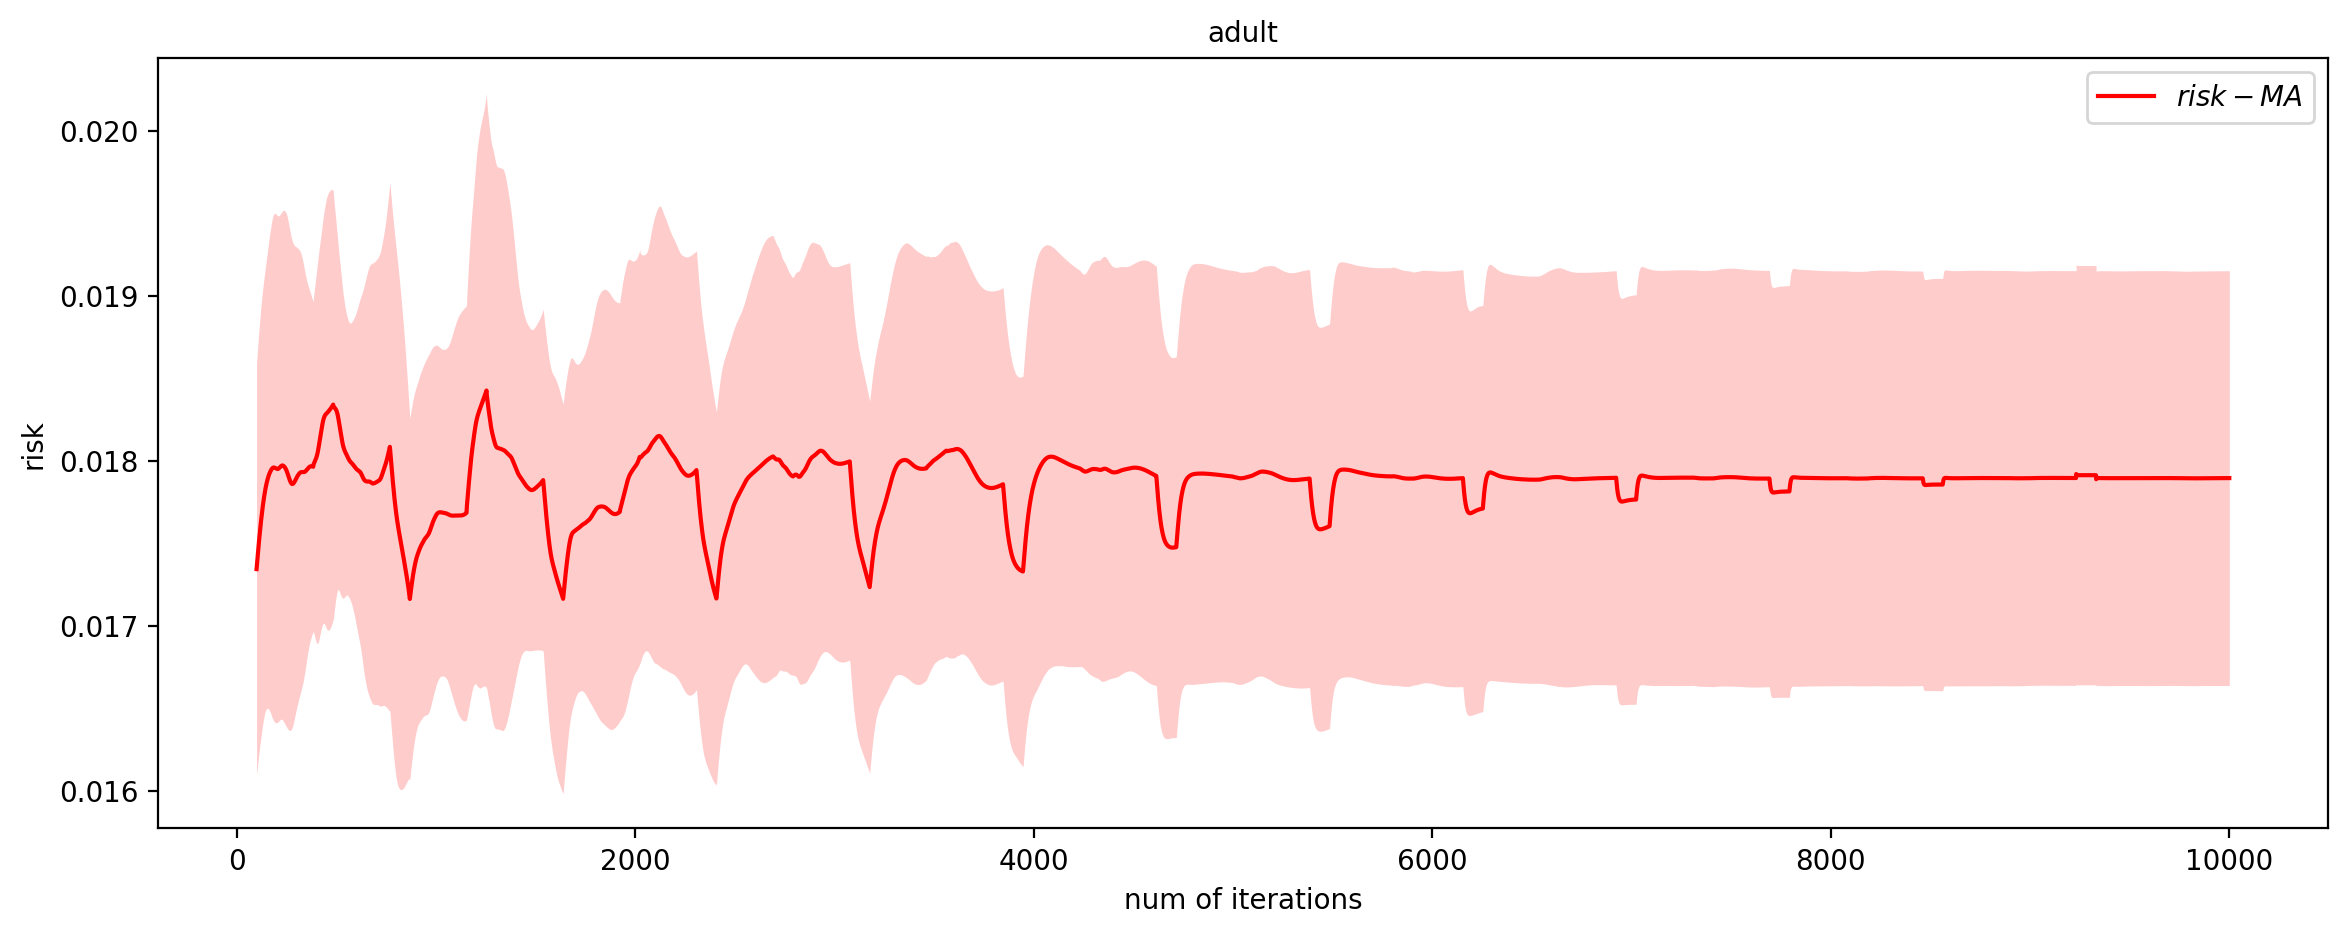

In [6]:
plot_risk_history(stats_adult['risk'], T=T, moving_av=100, dataset = 'adult', 
                  alpha=1, color='r', x_label = 'num of iterations', y_label='risk')

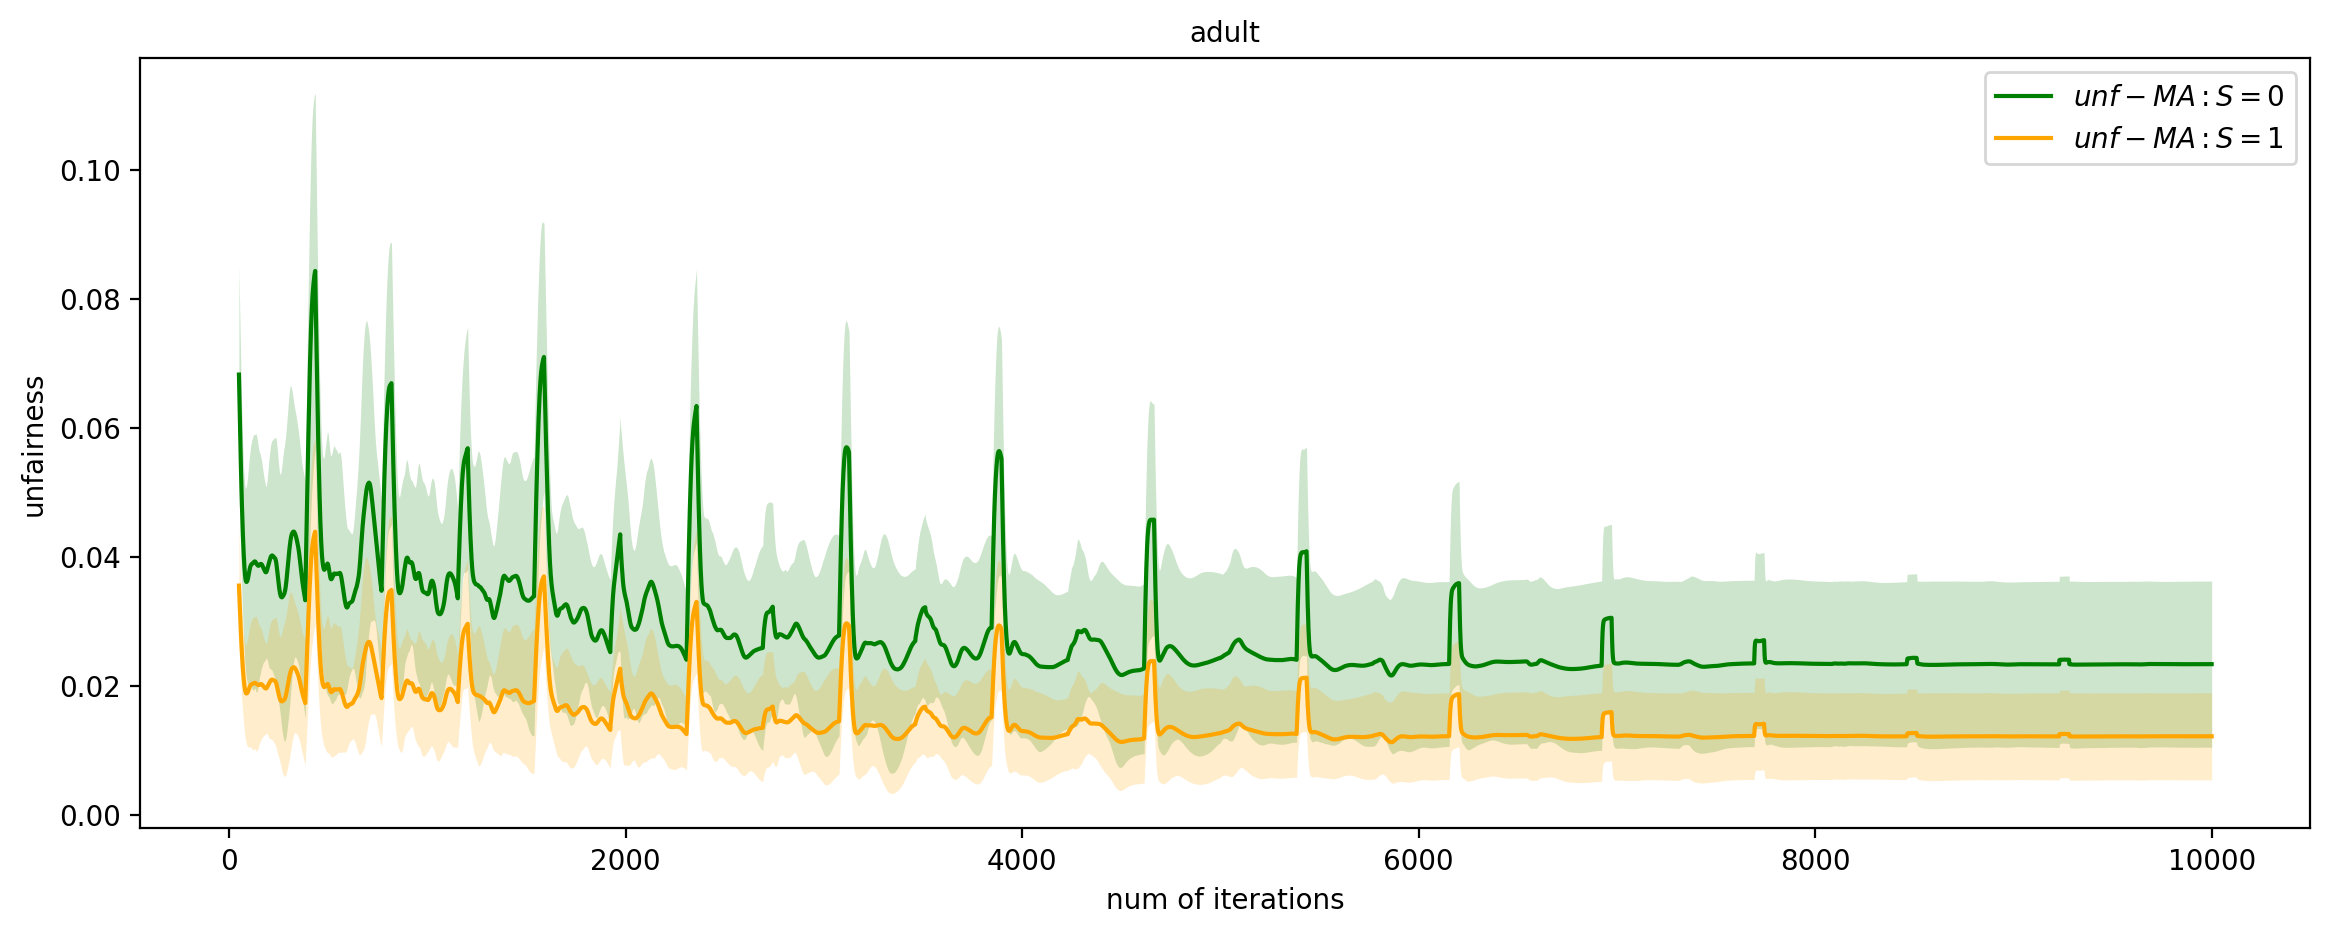

In [7]:
plot_unfairness_history(stats_adult['unf'], T=T, moving_av=50, K=2, dataset='adult', 
                        alpha=1, colors = ['g', 'orange'], x_label='num of iterations', y_label='unfairness')

__________________________